In [1]:
!git clone https://github.com/fxia22/pointnet.pytorch
%cd pointnet.pytorch
!pip install -e .

Cloning into 'pointnet.pytorch'...
remote: Enumerating objects: 209, done.
remote: Total 209 (delta 0), reused 0 (delta 0), pack-reused 209
Receiving objects: 100% (209/209), 228.65 KiB | 2.00 MiB/s, done.
Resolving deltas: 100% (123/123), done.
/content/pointnet.pytorch
Obtaining file:///content/pointnet.pytorch
  Running setup.py develop for pointnet


In [2]:
from google.colab import drive
drive.mount("/gdrive")

Mounted at /gdrive


In [3]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from tqdm.notebook import tqdm


import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from pointnet.model import PointNetCls

import warnings
warnings.filterwarnings("ignore")

In [4]:
classes = {
    "A" : 0,
    "B" : 1,
    "C" : 2
}

In [5]:
root_dir = "/gdrive/MyDrive/DPA_assignment1_dataset"
train_dir = os.path.join(root_dir, "train")
test_dir = os.path.join(root_dir, "test")

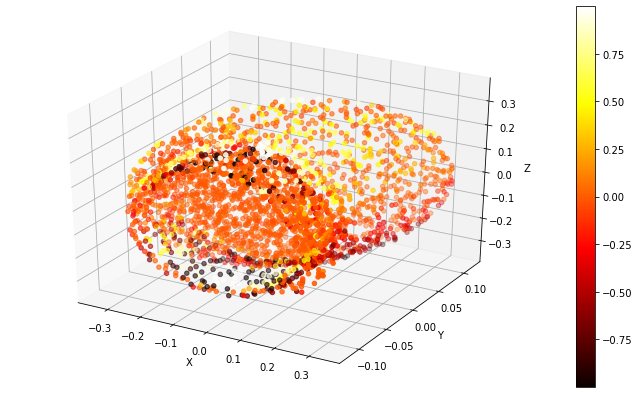

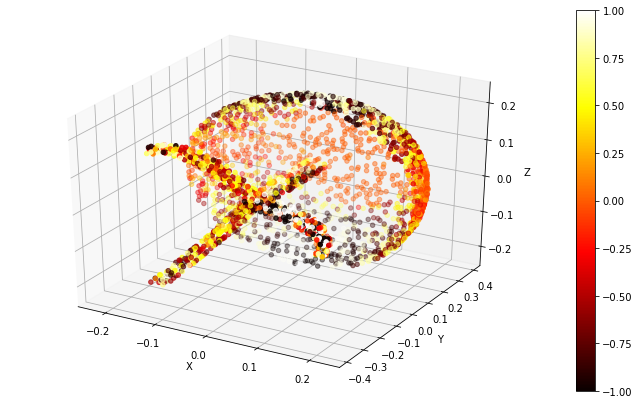

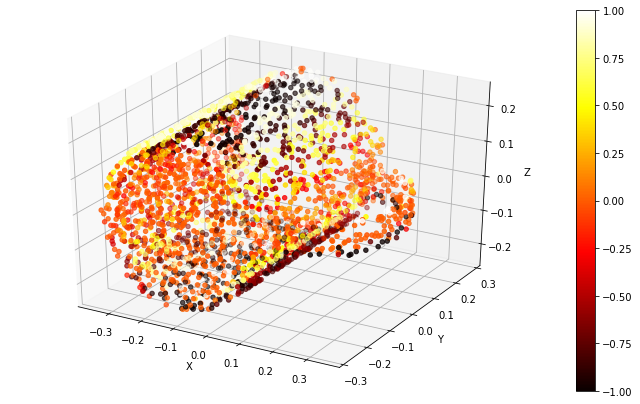

In [6]:
def random_sample_from_each_class(train_dir):
    for i, cls in enumerate(os.listdir(train_dir)):
        cls_dir = os.path.join(train_dir, cls)
        cls_txt_dir = os.path.join(
            cls_dir,
            random.choice(os.listdir(cls_dir))
        )
        xs = []
        ys = []
        zs = []
        tlows = []
        #f = open(cls_txt_dir)
        #print(f.readline())
        input_ = np.loadtxt(cls_txt_dir)
        #print(input_.shape)
        fig = plt.figure(figsize=(12,7))
        ax = fig.add_subplot(projection='3d')
        #print(input_[0,:])
        img = ax.scatter(input_[:,0], input_[:,1], input_[:,2], c=input_[:,-2], cmap=plt.hot())
        fig.colorbar(img)

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        plt.show()
random_sample_from_each_class(train_dir)

In [7]:
def get_input_data_dirs(dir):
    file_dirs = []
    Ys = []
    for i, cls_dir in enumerate(os.listdir(dir)):
        c = classes[cls_dir]
        cls_dir = os.path.join(dir, cls_dir)
        temp = [
                    os.path.join(cls_dir, f) for f in os.listdir(cls_dir)
        ]
        file_dirs+=temp
        Ys+=[c]*len(temp)

    return file_dirs, Ys

In [8]:
class PointCloud_Dataset(DataLoader):
    def __init__(self, X_dirs, Y, k, data_augmentation = True, n_pts = 2000, device="cpu"):
        self.X_dirs = X_dirs
        self.Y = Y
        self.k = k
        self.n_pts = n_pts
        self.device = device
        self.data_augmentation = data_augmentation

    def __len__(self):
        return len(self.X_dirs)

    def get_data(self, dir):
        Inputs = np.loadtxt(dir)
        choices = np.random.choice(len(Inputs), self.n_pts, replace=True)
        Inputs = Inputs[choices, :3]
        Inputs = Inputs - np.expand_dims(np.mean(Inputs, axis = 0), 0) # center
        dist = np.max(np.sqrt(np.sum(Inputs ** 2, axis = 1)),0)
        Inputs = Inputs / dist #scale
        if self.data_augmentation:
            theta = np.random.uniform(0,np.pi*2)
            rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
            Inputs[:,[0,2]] = Inputs[:,[0,2]].dot(rotation_matrix) # random rotation
            Inputs += np.random.normal(0, 0.02, size=Inputs.shape) # random jitter
        Inputs = Inputs.transpose()
        Inputs = torch.tensor(Inputs, dtype = torch.float).to(self.device)
        return Inputs

    def __getitem__(self, idx):
        X_dir = self.X_dirs[idx]
        y = self.Y[idx]
        onehot = torch.zeros(self.k)
        onehot[y] = 1
        onehot = torch.tensor(onehot, dtype = torch.float).to(self.device)
        Inputs = self.get_data(X_dir)
        return Inputs, onehot

#dummy_dataloader = PointCloud_Dataset(*get_input_data_dirs(train_dir), 3)
#for i in range(len(dummy_dataloader)):
#    dummy_inputs, dummy_onehots = dummy_dataloader.__getitem__(i)
#    print(dummy_inputs.size())
#    print(dummy_onehots.size())

In [9]:
class Trainer:
    def __init__(self, model, optimizer, device ,scheduler = None,):
        self.model = model
        self.optimizer = optimizer 
        self.scheduler = scheduler
        self.device = device
        self.best_acc = None
        self.model.to(self.device)
    
    def loss_fn(self, labels, outputs, gamma = 0.5):
        #outputs = torch.clip(outputs, 1e-4, 1-1e-4)
        l = -labels*((1-torch.exp(outputs))**gamma)*outputs
        l = l.sum(-1)
        return l

    def fit_one_epoch(self, train_loader, len_):
        train_loader = tqdm(train_loader)
        train_loader = enumerate(train_loader)
        self.model.train()
        l = 0
        acc = 0 
        for i, (Inputs, labels) in train_loader:

            outputs,_,_ = self.model(Inputs)
            loss = self.loss_fn(labels, outputs)

            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
            acc += (outputs.detach().cpu().numpy().argmax(-1) == labels.cpu().numpy().argmax(-1)).sum()
            l+=loss.sum().detach().item()
        l/=len_
        acc/=len_
        return l, acc
    def validate_one_epoch(self, valid_loader, len_, load_best = None):
        if load_best is not None:
            self.load(load_best)
        
        valid_loader = tqdm(valid_loader)
        valid_loader = enumerate(valid_loader)
        self.model.eval()
        l = 0
        acc = 0
        for i, (Inputs, labels) in valid_loader:
            outputs,_,_ = self.model(Inputs)
            
            loss = self.loss_fn(labels, outputs)
            l+=loss.sum().detach().item()
            acc += (outputs.detach().cpu().numpy().argmax(-1)==labels.cpu().numpy().argmax(-1)).sum()
        l/=len_
        acc/=len_
        return l, acc
    def save(self,acc, filename):
        if self.best_acc == None:
            self.best_acc = acc
            torch.save(self.model.state_dict(), root_dir + f"/model_{filename}.pth")
            print("weight saved!!")
            
        elif acc > self.best_acc:
            self.best_acc = acc
            torch.save(self.model.state_dict(), root_dir + f"/model_{filename}.pth")
            print("weight saved!!")
        else:
            pass

    def load(self, filename):
        self.model.load_state_dict(torch.load(root_dir + f"/model_{filename}.pth"))
        k = root_dir + f"/model_{filename}.pth"
        print(f"loaded weights from {k}")

    def accuracy(self, preds, labels):
        preds = torch.argmax(preds, dim=-1)
        if(len(labels.shape)!=1):
            labels = torch.argmax(labels, dim=-1)
        return (preds==labels).sum()/preds.shape[0]

    def fit(self, epochs, train_loader, train_len, filename, valid_loader=None, valid_len = None):
        for i in range(epochs):
            train_loss, train_acc = self.fit_one_epoch(train_loader, len_=train_len)
            if valid_loader:
                valid_loss, valid_acc = self.validate_one_epoch(valid_loader, len_=valid_len)
                self.save(valid_acc, filename)
                print("epoch : {} | train loss : {} | valid loss : {} | train acc : {} | valid acc : {}".format(
                    i, train_loss, valid_loss, train_acc, valid_acc
                ))
            else:
                self.save(train_acc, filename)
                print("epoch : {} | train loss : {} | train acc : {}".format(
                    i, train_loss, train_acc
                ))
            

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
X_dirs, Y = get_input_data_dirs(train_dir)
print(len(X_dirs), len(Y))


1071 1071


In [13]:
print(Y)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [14]:
print((np.asarray(Y)==0).sum())
print((np.asarray(Y)==1).sum())
print((np.asarray(Y)==2).sum())

33
928
110


In [15]:
X_dirs = np.asarray(X_dirs)
Y = np.asarray(Y)
kfold = KFold(5)
X_test, Y_test = get_input_data_dirs(test_dir)
for fold,(train, test) in enumerate(kfold.split(X_dirs, Y)):
    pointnet_classifier = PointNetCls(k=3, feature_transform = True)
    X_train, y_train, X_val, y_val = X_dirs[train], Y[train], X_dirs[test], Y[test]
    train_dataset = PointCloud_Dataset(
        X_train, y_train, 3, device = device
    )
    valid_dataset = PointCloud_Dataset(
        X_val, y_val, 3, device = device,   data_augmentation = False,
    )
    test_dataset = PointCloud_Dataset(
        X_test, Y_test, 3, device = device,   data_augmentation = False,
    )
    train_loader = DataLoader(
        train_dataset,
        batch_size = 32,
        shuffle = True
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size = 32,

        shuffle = True
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size = 32,

        shuffle = True
    )
    optimizer = Adam(pointnet_classifier.parameters(), lr = 5e-4)
    trainer = Trainer(
        pointnet_classifier,
        optimizer,
        device,
    )
    print("#"*30)
    print("#"*10, "FOLD : {}".format(fold))
    print("#"*30)
    trainer.fit(8, 
                train_loader, 
                valid_loader = valid_loader,  
                train_len = len(train_dataset),
                valid_len = len(valid_dataset),
                filename = f"best_model_{fold}")
    test_loss, test_acc = trainer.validate_one_epoch(test_loader, len_ = len(test_dataset), load_best = f"best_model_{fold}")
    print("#"*10)
    print("#"*5, f'test acc : {test_acc} , test loss : {test_loss}')

##############################
########## FOLD : 0
##############################


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

weight saved!!
epoch : 0 | train loss : 0.3019449131511082 | valid loss : 0.3993964439214662 | train acc : 0.9100467289719626 | valid acc : 0.8465116279069768


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch : 1 | train loss : 0.0724681550375769 | valid loss : 0.35386385806771214 | train acc : 0.9754672897196262 | valid acc : 0.8465116279069768


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch : 2 | train loss : 0.06480443390591123 | valid loss : 0.3962699890136719 | train acc : 0.9742990654205608 | valid acc : 0.8325581395348837


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch : 3 | train loss : 0.06113077661840715 | valid loss : 0.6944866136062977 | train acc : 0.977803738317757 | valid acc : 0.8325581395348837


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch : 4 | train loss : 0.0623084244396642 | valid loss : 0.385243877144747 | train acc : 0.977803738317757 | valid acc : 0.8465116279069768


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch : 5 | train loss : 0.045828441558318715 | valid loss : 0.38239769602930823 | train acc : 0.9871495327102804 | valid acc : 0.8465116279069768


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch : 6 | train loss : 0.07026122416430544 | valid loss : 0.6237149526906568 | train acc : 0.9649532710280374 | valid acc : 0.8418604651162791


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch : 7 | train loss : 0.047886805904802876 | valid loss : 0.6388100113979606 | train acc : 0.9766355140186916 | valid acc : 0.8418604651162791
loaded weights from /gdrive/MyDrive/DPA_assignment1_dataset/model_best_model_0.pth


  0%|          | 0/12 [00:00<?, ?it/s]

##########
##### test acc : 0.865546218487395 , test loss : 0.44459504039347675
##############################
########## FOLD : 1
##############################


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

weight saved!!
epoch : 0 | train loss : 0.27801947165258845 | valid loss : 0.14098657625857916 | train acc : 0.911318553092182 | valid acc : 1.0


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch : 1 | train loss : 0.11091222966148528 | valid loss : 0.060547949554764224 | train acc : 0.9568261376896149 | valid acc : 1.0


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch : 2 | train loss : 0.11101346915911627 | valid loss : 0.04536377993699546 | train acc : 0.9521586931155193 | valid acc : 1.0


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch : 3 | train loss : 0.08245167209220183 | valid loss : 0.08403991093145352 | train acc : 0.9719953325554259 | valid acc : 0.985981308411215


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch : 4 | train loss : 0.06621445310296645 | valid loss : 0.028717476909405716 | train acc : 0.9684947491248541 | valid acc : 1.0


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch : 5 | train loss : 0.048556938350131106 | valid loss : 0.02315700625147775 | train acc : 0.9789964994165694 | valid acc : 1.0


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch : 6 | train loss : 0.06739622825711027 | valid loss : 0.04480738951781086 | train acc : 0.969661610268378 | valid acc : 1.0


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch : 7 | train loss : 0.04593296190821582 | valid loss : 0.025692468770196503 | train acc : 0.9801633605600933 | valid acc : 1.0
loaded weights from /gdrive/MyDrive/DPA_assignment1_dataset/model_best_model_1.pth


  0%|          | 0/12 [00:00<?, ?it/s]

##########
##### test acc : 0.865546218487395 , test loss : 0.4277818057717395
##############################
########## FOLD : 2
##############################


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

weight saved!!
epoch : 0 | train loss : 0.2940092426197671 | valid loss : 0.2047146815005864 | train acc : 0.8903150525087514 | valid acc : 1.0


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch : 1 | train loss : 0.12690052546586847 | valid loss : 0.0974818345542266 | train acc : 0.9358226371061844 | valid acc : 0.9953271028037384


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch : 2 | train loss : 0.10189603090008054 | valid loss : 0.32416196069984793 | train acc : 0.9521586931155193 | valid acc : 0.9158878504672897


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch : 3 | train loss : 0.0802411747229141 | valid loss : 0.047212037806198974 | train acc : 0.9684947491248541 | valid acc : 1.0


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch : 4 | train loss : 0.0864798371683341 | valid loss : 0.1297072038472256 | train acc : 0.9603267211201867 | valid acc : 0.9672897196261683


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch : 5 | train loss : 0.08562504605345576 | valid loss : 0.07541517955120479 | train acc : 0.970828471411902 | valid acc : 1.0


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch : 6 | train loss : 0.07418982835884272 | valid loss : 0.054091572204482886 | train acc : 0.9719953325554259 | valid acc : 1.0


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch : 7 | train loss : 0.05782517138759898 | valid loss : 0.043522601372727725 | train acc : 0.9789964994165694 | valid acc : 0.9953271028037384
loaded weights from /gdrive/MyDrive/DPA_assignment1_dataset/model_best_model_2.pth


  0%|          | 0/12 [00:00<?, ?it/s]

##########
##### test acc : 0.865546218487395 , test loss : 0.4399041795597023
##############################
########## FOLD : 3
##############################


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

weight saved!!
epoch : 0 | train loss : 0.3177255449105867 | valid loss : 0.1362572852696214 | train acc : 0.8868144690781797 | valid acc : 1.0


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch : 1 | train loss : 0.12773694930861126 | valid loss : 0.07066746292827285 | train acc : 0.9486581096849475 | valid acc : 0.9953271028037384


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch : 2 | train loss : 0.10005006420153303 | valid loss : 0.07612067182487417 | train acc : 0.9614935822637106 | valid acc : 0.985981308411215


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch : 3 | train loss : 0.07693068420594881 | valid loss : 0.054716417165560145 | train acc : 0.970828471411902 | valid acc : 0.9953271028037384


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch : 4 | train loss : 0.07372843874933561 | valid loss : 0.031409494509206756 | train acc : 0.9778296382730455 | valid acc : 1.0


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch : 5 | train loss : 0.08837937161135145 | valid loss : 0.033657204324954025 | train acc : 0.9661610268378062 | valid acc : 1.0


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch : 6 | train loss : 0.06481328422297118 | valid loss : 0.024280696828788684 | train acc : 0.9673278879813302 | valid acc : 1.0


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch : 7 | train loss : 0.04689088187320647 | valid loss : 0.06879973745791712 | train acc : 0.9801633605600933 | valid acc : 0.9672897196261683
loaded weights from /gdrive/MyDrive/DPA_assignment1_dataset/model_best_model_3.pth


  0%|          | 0/12 [00:00<?, ?it/s]

##########
##### test acc : 0.865546218487395 , test loss : 0.40166595269318056
##############################
########## FOLD : 4
##############################


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

weight saved!!
epoch : 0 | train loss : 0.39067972944386503 | valid loss : 0.8238143831769996 | train acc : 0.8716452742123687 | valid acc : 0.48598130841121495


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch : 1 | train loss : 0.08664449732946265 | valid loss : 1.0585070369399596 | train acc : 0.9719953325554259 | valid acc : 0.48598130841121495


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch : 2 | train loss : 0.07154655929485308 | valid loss : 1.445461790138316 | train acc : 0.9673278879813302 | valid acc : 0.48598130841121495


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch : 3 | train loss : 0.06807326790610439 | valid loss : 1.8584184557478005 | train acc : 0.9649941656942824 | valid acc : 0.48598130841121495


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch : 4 | train loss : 0.055182026418810544 | valid loss : 2.0731372120224427 | train acc : 0.9743290548424738 | valid acc : 0.48598130841121495


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch : 5 | train loss : 0.05176715603230854 | valid loss : 1.8413686574062453 | train acc : 0.9673278879813302 | valid acc : 0.48598130841121495


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch : 6 | train loss : 0.03864525830592686 | valid loss : 2.1568308143972237 | train acc : 0.9824970828471412 | valid acc : 0.48598130841121495


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch : 7 | train loss : 0.04034095185362194 | valid loss : 3.857546583514347 | train acc : 0.9813302217036173 | valid acc : 0.4719626168224299
loaded weights from /gdrive/MyDrive/DPA_assignment1_dataset/model_best_model_4.pth


  0%|          | 0/12 [00:00<?, ?it/s]

##########
##### test acc : 0.865546218487395 , test loss : 0.5328131710447851


In [19]:
def test(weights, model, test_dataloader, len_):
    test_dataloader = tqdm(test_dataloader)
    test_dataloader = enumerate(test_dataloader)
    acc = 0
    for i, (Inputs, labels) in test_dataloader:
        outputs = 0
        for weight in weights:
            model.load_state_dict(torch.load(root_dir + f"/model_{weight}.pth"))
            model.eval()
            o, _, _ = model(Inputs)
            outputs+=o
        acc += (outputs.detach().cpu().numpy().argmax(-1)==labels.cpu().numpy().argmax(-1)).sum()
    acc/=len_
    return acc

print(test(
    ["best_model_0","best_model_1","best_model_2","best_model_3","best_model_4"],
    pointnet_classifier,
    test_loader, 
    len(test_dataset)
))

  0%|          | 0/12 [00:00<?, ?it/s]

0.865546218487395
